In [ ]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from astropy.coordinates import SkyCoord, Distance
#import popsims
import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
from popsims import sample_from_powerlaw
import astropy.units as u
from tqdm import tqdm
import popsims
import pandas as pd
from easyshapey import Box
from scipy.interpolate import interp1d, griddata
from findthegap.gapper import Gapper
import torch
#paths

plot_style()

path_isochrone='../data/isochrones/'
path_data='../data/images/'
path_streamdata='../data/stream/'
path_pipeline='../data/pipeline/'
path_pandas= '../data/pandas/'

In [2]:
rgc='10_20'
mag_limit=28.69
mhalo=5e6
vhalo=-50
d_galaxy=770*u.kpc

kpc_conversion = np.pi * d_galaxy / 180.
roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)

gap_centers={'10_20': (2.5, 6.), '30_40': (2.5, 6.), '50_60': (2.5, 6)}
rotation_angles={'10_20': -20.*u.degree.to(u.radian),
                '30_40': -20.*u.degree.to(u.radian),
                '50_60': -20.*u.degree.to(u.radian)}

mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']

In [3]:
fname=path_isochrone+'simulated_df_at_M31_normalized_extended_rgc{}.csv'.format(rgc)
MASTER_DF=pd.read_csv(fname)
#metallicity cut

In [4]:
MASTER_DF=MASTER_DF.query('MH < -1').reset_index(drop=True)

In [5]:
#read stream
def read_stream_file(N_pal5, gap_center, box, rgc, mhalo, vhalo, rotate_by=-np.pi/8):
    
    #filename='pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}'.format(rgc, mhalo, vhalo)
    distance_to_hit =0.5
    filename='pal5_rgc{}_mhalo{:.2e}_vhalo{:.0f}_distance_to_hit{}'.format(rgc, mhalo, vhalo, distance_to_hit )
    st=(np.load(path_streamdata+'/{}.npy'.format(filename), allow_pickle=True).flatten()[0])['stream']
    
    x=st.y.value
    y=st.x.value

    
    center=np.nanmedian(np.array(rgc.split('_')).astype(float))
    
    xshift= np.nanmedian(x)-gap_center[0]
    yshift=np.nanmedian(y)-gap_center[1]
    
    x0=x-xshift
    y0=y-yshift
    
    x0, y0= rotate(x0, y0, rotate_by, c=(np.nanmedian(x0), np.nanmedian(y0)))
    
    xshift= np.nanmedian(x0)-center
    yshift=np.nanmedian(y0)-center
    
    x0=x0-xshift
    y0=y0-yshift
    
    choose=np.random.choice(np.arange(len(x0)), N_pal5)
    
    return box.select(np.array([x0[choose], y0[choose]]))
    
def read_cmd_file(rgc, d_galaxy, mag_limit):
    df=MASTER_DF
    d_m31= 770*u.kpc
    dmod_m31=5*np.log10(d_m31.to(u.pc).value/10.0)
    
    dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
    dmod_diff= dmod_galaxy-dmod_m31
    
    #put to the desired distance modulus 
    mw_df= df.query("galaxy == 'MW'").reset_index(drop=True)
    m31_df= df.query("galaxy =='M31'").reset_index(drop=True)
    
    for k in ['appF062mag', 'appF087mag', 'appgmag', 'appimag']:
         m31_df[k]=  m31_df[k].values+dmod_diff
            
    #appply magnitude cut
    df_final=pd.concat([m31_df, mw_df]).reset_index(drop=True)
    df_final=(df_final[df_final.appF087mag < mag_limit]).reset_index(drop=True)
    
    
    #assign RA, DEC, xki based on the data
    from astropy.io.votable import parse_single_table
    data=parse_single_table(path_pandas+'M31_{}kpc_new.vot'.format(rgc)).to_table().to_pandas()
    
    
    for k in ['RA', 'Dec','xki', 'eta']:
        df_final[k]=np.random.choice(data[k].values, len(df_final), replace=True)
              
    s=SkyCoord(ra=df_final.RA, dec=df_final.Dec,frame = 'icrs', unit = (u.hourangle, u.deg))
    
    center=np.nanmedian(np.array(rgc.split('_')).astype(float))
              
    shift_x=np.nanmedian(kpc_conversion.value*(s.ra.to(u.degree).value))-center
    shift_y=np.nanmedian(kpc_conversion.value*(s.dec.to(u.degree).value))-center
    
    df_final['x_coord']=kpc_conversion.value*(s.ra.to(u.degree).value)-shift_x
    df_final['y_coord']=kpc_conversion.value*(s.dec.to(u.degree).value)-shift_y
    
    return df_final

def boostrap_density_estimate(gapper_base, bw, grid_data, data, bounds, nboostrap, max_eigenvalue=True):
    ##purpose: with a gapper object, 
    #we can estimate the hessian and the maximum eigevalue by boostrapping
    PiHPi_boots=[]
    maxeigval_PiHPi_boots =[]

    mineigval_PiHPi_boots =[]
    
    #loop over all bootstraps
    for i in range(nboostrap):
        boot_indx = np.random.choice(np.arange(data.shape[0]), data.shape[0], 
                                     replace=True) ## Sample with replacement:bootstrap

        gapper_ = Gapper(data[boot_indx], bw, bounds)
        PiHPis_grid = []
        eigval_PiHPi = [] 

        for pt in grid_data:
            _pihpi = gapper_.get_PiHPi(pt) 
            _pihpi_eigval, _pihpi_eigvec = np.linalg.eigh(_pihpi)

            PiHPis_grid.append(_pihpi)
            eigval_PiHPi.append(_pihpi_eigval)
            #print (eigval_PiHPi)

        PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)
        
        #option for using minium or maximum eigenvalue
        #if max_eigenvalue:
        max_eigval_PiHPi_k = np.nanmax(eigval_PiHPi, axis=1)
        #rescale everything between 0 and 1
        max_eigval_PiHPi_k = (max_eigval_PiHPi_k-np.nanmin(max_eigval_PiHPi_k))/(np.nanmax(max_eigval_PiHPi_k)-np.nanmin(max_eigval_PiHPi_k))

        #if not max_eigenvalue:
        min_eigval_PiHPi_k = np.nanmin(eigval_PiHPi, axis=1)
        min_eigval_PiHPi_k = (min_eigval_PiHPi_k-np.nanmin(min_eigval_PiHPi_k))/(np.nanmax(min_eigval_PiHPi_k)-np.nanmin(min_eigval_PiHPi_k))


        maxeigval_PiHPi_boots.append(max_eigval_PiHPi_k)
        mineigval_PiHPi_boots.append(min_eigval_PiHPi_k)

        PiHPi_boots.append(PiHPis_grid)
        print(f'Run {i} finished')
        
    return np.array(maxeigval_PiHPi_boots), np.array(mineigval_PiHPi_boots), np.array(PiHPi_boots)


def find_gaps(bw, data, nboostrap=5):
    n= 100
    
    bounds = np.array([[np.min(data[:,d]),np.max(data[:,d])] for d in range(data.shape[1])])

    #scale of y to 
    x_to_y= np.ptp(data[:,0])/ np.ptp(data[:,1])
    
    gridding_size = [ n, np.int(0.1*n/x_to_y)]

    
    grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(2) ]
    #could use a rectangular grid instead


    meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
    grid_data = np.hstack(meshgrid_ravel)
    
    gapper_base = Gapper(data, bw, bounds)
    grid_density = gapper_base.kde.score_samples(torch.tensor(grid_data))
    #density matrix 
    density_matr = grid_density.reshape((gridding_size[0], gridding_size[1]))

    #compute piHpi matrix by bootstraping
    maxeigval_PiHPi_boots,  mineigval_PiHPi_boots, PiHPi_boots = boostrap_density_estimate(gapper_base, bw,\
                                                                   grid_data, data, bounds, nboostrap,\
                                                                   max_eigenvalue=max_eigenvalue)
    
    #visualize and take the median
    maxeigval_PiHPi_boots = np.array(maxeigval_PiHPi_boots)
    mineigval_PiHPi_boots = np.array(mineigval_PiHPi_boots)
    
    #median
    med_maxeigval_pihpi = np.median(maxeigval_PiHPi_boots, axis=0)
    med_maxeigval_pihpi_resh = med_maxeigval_pihpi.reshape((gridding_size[0], gridding_size[1]))

    med_mineigval_pihpi = np.median(mineigval_PiHPi_boots, axis=0)
    med_mineigval_pihpi_resh = med_mineigval_pihpi.reshape((gridding_size[0], gridding_size[1]))
    
    return  {'density':density_matr, \
              'max_eigen':med_maxeigval_pihpi_resh,
              'min_eigen':med_mineigval_pihpi_resh,
              'meshgrid':meshgrid, 
              'PiHPi': PiHPi_boots,
              'bw_rescale': scale,
              'data': data}

def count_pal5_stars(mag_limit, dmod):
    dmod_pal5=16.85
    def read_pandas_isochrones():
        from astropy.io import ascii
        return ascii.read(path_isochrone+'/cfht_pre2014_isochrones_pal5.txt').to_pandas()

    def read_roman_isochrones():
        from astropy.io import ascii
        return ascii.read(path_isochrone+'/roman_isochrones_vega_pal5.txt').to_pandas()
    
    nsample=1e6
    masses= sample_from_powerlaw(-.5, xmin=0.1, xmax=120, nsample=nsample)
    cfht=read_pandas_isochrones()
    roman= read_roman_isochrones()
    comb= pd.concat([cfht, roman]).reset_index()
    
    
    isos={}
    for k in mag_keys:
        x= np.log10(comb.Mini.values)
        y=comb[k].values
        nans=np.logical_or(np.isnan(x), np.isnan(y))
        isos['mass']= masses
        #f=griddata(x[~nans], y[~nans], np.log10(masses) , fill_value=np.nan, method='linear', rescale=True)
        sort=np.argsort(x[~nans])
        f=interp1d(x[~nans][sort], y[~nans][sort], fill_value =np.nan, bounds_error=False)(np.log10(masses))
        isos.update({k: f+dmod_pal5})
    
    df=pd.DataFrame(isos)
    
    num_20_23= len(df.gmag.values[np.logical_and(df.gmag.values>=20, df.gmag.values<=23)])
    norm= (3000/num_20_23)
    
    #compute the difference between distance moduli and offset stars
    dist_mod_And = dmod- dmod_pal5
    
    return len(df.F087mag.values[df.F087mag.values<(mag_limit-dist_mod_And)])*norm

In [6]:
def make_box(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    return b

def rotate(x, y, ang, c=(0,0)):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

In [7]:
center=np.nanmedian(np.array(rgc.split('_')).astype(float))
b=make_box( (center, center), roman_fov.value, roman_fov.value)

In [8]:
dmod_galaxy=5*np.log10(d_galaxy.to(u.pc).value/10.0)
N_pal5=int(count_pal5_stars(mag_limit, dmod_galaxy))
vls=read_stream_file(N_pal5, gap_centers[rgc], b, rgc, mhalo, vhalo, rotate_by=rotation_angles[rgc])

In [9]:
bck=read_cmd_file(rgc, 770*u.kpc, mag_limit)

In [10]:
s=b.select(bck[['x_coord', 'y_coord']])

In [11]:
img= [np.concatenate([vls[0], s.x.values]),
      np.concatenate([vls[1], s.y.values])]

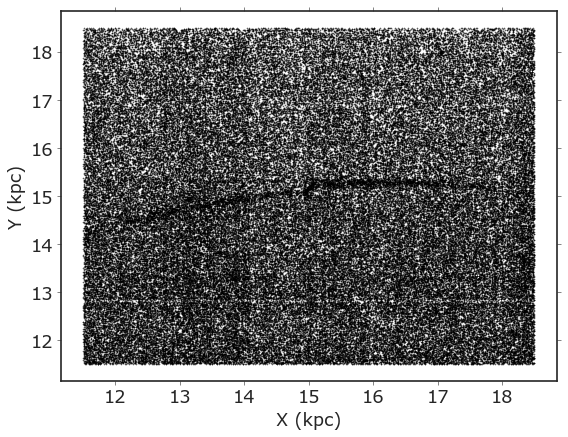

In [12]:
fig, ax=plt.subplots()

ax.scatter(img[0], img[1], s=.1, c='k')
ax.set(xlabel='X (kpc)', ylabel='Y (kpc)')
plt.savefig('../figures/mock_image_m31_rgc{}.jpeg'.format(rgc))
#ax.set(ylim=[13.5, 14.4], xlim=[12, 18]

In [21]:
b=make_box((17, 15), 5, 2)

In [22]:
s=b.select(np.array(img))

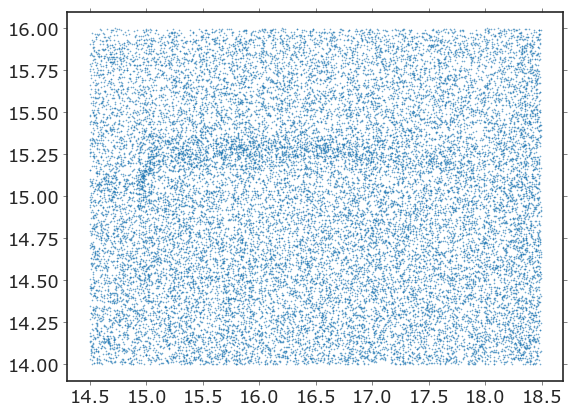

In [24]:
fig, ax=plt.subplots()
ax.scatter(s[0], s[1], s=.1)

In [1]:
gapper_base = Gapper()

NameError: name 'Gapper' is not defined